#                                                Digit Recognizer

MNIST ("Modified National Institute of Standards and Technology") is the de facto “hello world” dataset of computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms. 

The goal is to correctly identify digits from a dataset of tens of thousands of handwritten images. 

In [245]:
#To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io
import warnings
warnings.filterwarnings('ignore')

# Using Decision Tree Classifier

A decision tree is a hierarchical data structure implementing the divide-and-conquer strategy. It is an efficient nonparametric method, which can be used for both classification and regression. 

Load data

In [246]:
# Load data
train = pd.read_csv('datasets/mnist/train.csv')
test = pd.read_csv('datasets/mnist/test.csv')
print (train.shape)
print (train.head())
print (test.shape)

(42000, 785)
   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8    ...     pixel774  pixel775  pixel776  pixel777  pixel778  \
0       0    ...            0         0         0         0         0   
1       0    ...            0         0         0         0         0   
2       0    ...            0         0         0         0         0   
3       0    ...            0         0         0         0         0   
4       0    ...            0         0         0         0         0   

   pixel779  pixel780  pixel781  pixel782  pixel783  
0         0         0         0      

Check for null and missing values

In [247]:
train.isnull().any().describe()

count       785
unique        1
top       False
freq        785
dtype: object

In [248]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [249]:
X = train.drop('label', axis=1)
Y = train.label

Splitting data for training and testing: Training data: 80% Test data: 20%

In [250]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(train, train['label'], 
                                                    test_size=.2, random_state=42)
print(x_train.shape)
print(x_test.shape)

(33600, 785)
(8400, 785)


In [251]:
from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier(max_depth=5)
classifier.fit(x_train,y_train)
y_pred = classifier.predict(x_train)
print ("Accuracy on Training: ",sum(y_pred==y_train)/len(y_train))


classifier1 = DecisionTreeClassifier(max_depth=9)
classifier1.fit(X,Y)
predictions = classifier1.predict(test)
print (predictions)

Accuracy on Training:  0.9079464285714286
[2 0 9 ... 3 9 2]


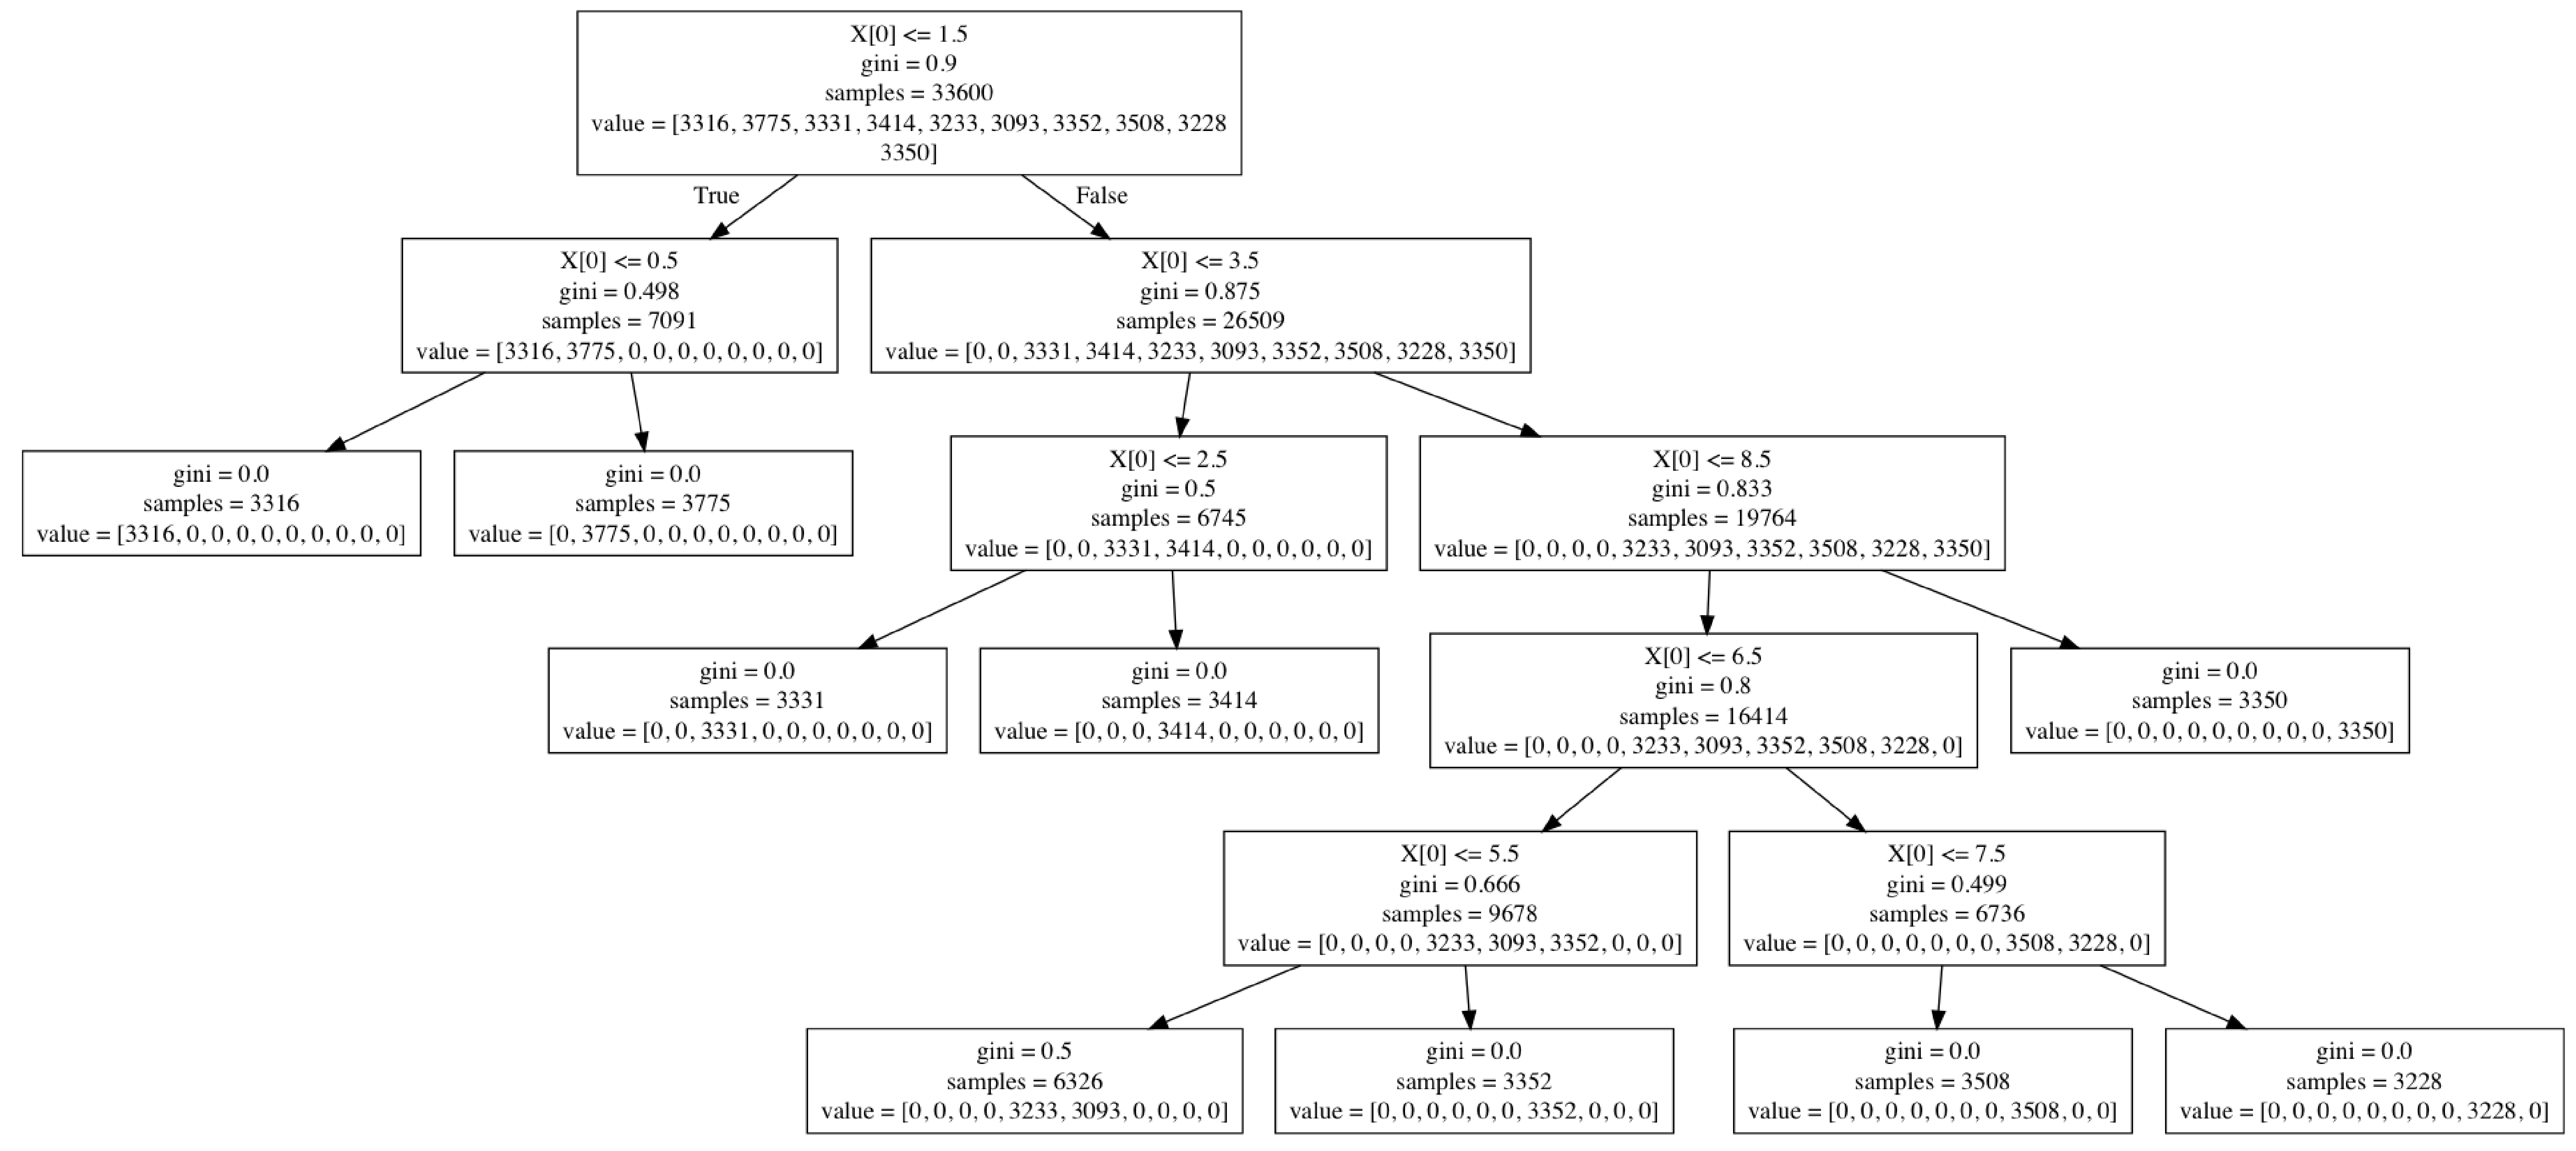

In [252]:
from io import StringIO
from sklearn import tree
#from graphviz import *

import matplotlib.image as mpimg
import pydotplus

dotfile = open("dtree2.dot", 'w')
tree.export_graphviz(classifier, out_file = dotfile)
dotfile.close()
dot_data = StringIO()
tree.export_graphviz(classifier, out_file=dot_data)
graph = pydotplus.graph_from_dot_file("dtree2.dot")
graph.write_png('test.png')
img=mpimg.imread('test.png')
fig = plt.figure(figsize=(100, 100)) 
plt.axis("off")
plt.imshow(img, cmap = plt.cm.binary,
           interpolation="nearest")
plt.show()


Saving data trained with decision tree

In [254]:
image_id = np.arange(1,predictions.shape[0]+1)
pd.DataFrame({"ImageId": image_id, "Label": predictions}).to_csv('datasets/mnist/decisionTree_output2.csv', 
                                                                      index=False, header=True)

# Logistic Regression 

In [236]:
# Load the data
train = pd.read_csv('datasets/mnist/train.csv').values
test = pd.read_csv('datasets/mnist/test.csv').values
print (train.shape)
print (test.shape)

(42000, 785)
(28000, 784)


In [237]:
X = (train[:,1:])
Y = (train[:,0])

Dimensionality Reduction using PCA(Principal Component Analysis). Below code plots a graph of component vs. cumulative explained variance. This graph will helps in choosing the number of components for training our data.

(42000, 412)


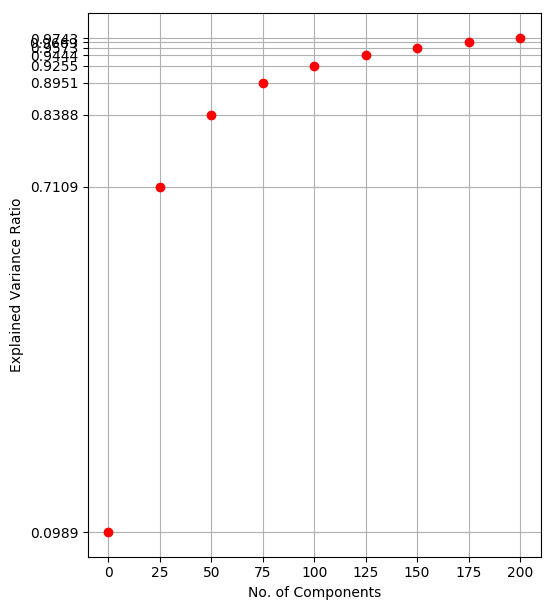

In [238]:
from sklearn.decomposition import PCA

# ## Removing the column with variance 0
variance = np.var(X, axis = 0)>1000
X = X[:, variance]
Test = test[0:,variance]
print(X.shape)

# ##Calculate Principal Components
pca = PCA()
pca.fit(X)
explained_variance = pca.explained_variance_ratio_

# ##Calculate cumulative explained ratio
cum_explained_variance = [np.sum(explained_variance[:i+1]) for i in range (0, 201, 25)]
X_axis = [i for i in range(0, 201,25)]

##Plot Graph
fig = plt.figure(figsize = (5.841, 7.195), dpi=100)
plt.plot(X_axis, cum_explained_variance, 'ro')
plt.grid(True, which = 'both')
plt.yticks(cum_explained_variance)
plt.xticks(X_axis)
plt.ylabel("Explained Variance Ratio")
plt.xlabel("No. of Components")
plt.show()


So Looking on the above graph, 50 components comprise 80% variance. So first we will go with 50 componets

Splitting data for training and testing: 
Training data: 80%
Test data: 20%

In [239]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size  = 0.20, random_state  = 42)

Define normalize function for normalizing the data, PrincipalComponents function to return top n principal components.

In [240]:
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler

def normalize(sigma2, mean2, X):
    X = (X-mean2)/sigma2
    return X

def PolynomialFeatures1(X):
    X_2 = np.square(X)
    X = np.column_stack((X, X_2))
    return X

J1 = []
J2 = []

##Take n principal components
def PrincipalComponents(n):
    pca = PCA(n_components= n)
    X_train1 = pca.fit_transform(X_train)
    X_test1 = pca.transform(X_test)
    return X_train1, X_test1

## Logistic Regression

def LogisticRegression(X_train2, y_train2, X_test2, y_test2, penalty):
    print("penalty= ", penalty)
    regr = linear_model.LogisticRegression(solver='lbfgs',max_iter=1000, C=penalty)
    regr.fit(X_train2, y_train2)
    score1 = regr.score(X_train2, y_train2)
    score2 = regr.score(X_test2, y_test2)
    print(score1, score2)
    Prediction = regr.predict(X_test2)
    return score1, score2, Prediction

Lets take top n components explaining the variance of 0.8 and also including thieir polynomials of degree 2.

(8400, 43) (33600, 43)
(8400, 989) (33600, 989)
penalty=  0.1
0.999280028798848 0.9727380952380953
penalty=  0.1
0.9992453114976794 0.9744047619047619
penalty=  0.1
0.998928609692511 0.9739285714285715
penalty=  0.1
0.9986780109148843 0.9746428571428571
penalty=  0.1
0.9982581207057837 0.9742857142857143
penalty=  0.1
0.9982769760930433 0.9741666666666666


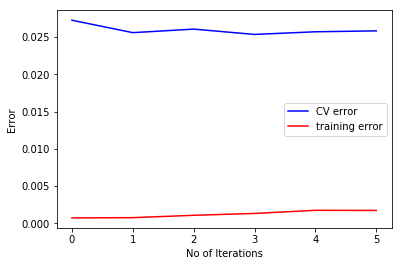

In [241]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(include_bias = False)
X_train1, X_test1 = PrincipalComponents(0.81)
print(X_test1.shape, X_train1.shape)

X_train1 = poly.fit_transform(X_train1)
X_test1 = poly.transform(X_test1)

print(X_test1.shape, X_train1.shape)

sigma = np.std(X_train1, axis = 0)
mean = np.mean(X_train1, axis = 0)

X_train1 = normalize(sigma , mean , X_train1)
X_test1 = normalize(sigma , mean, X_test1)

J1 = []
J2 = []
for i in range(25000, X_train1.shape[0], 1500):
    score1, score2, Prediction = LogisticRegression(X_train1[:i+1,:], 
                                                    y_train[:i+1, ], X_test1[:i+1,:], y_test[:i+1],0.1)
    J1.append(1-score1)
    J2.append(1-score2)
    
    
plt.plot(J2, 'b-', label = "CV error")
plt.plot(J1, 'r-', label ="training error")
plt.legend()
plt.ylabel("Error")
plt.xlabel("No of Iterations")
plt.show()

Saving data trained with logistic regression

In [242]:
from sklearn.preprocessing import PolynomialFeatures
# poly = PolynomialFeatures(include_bias = False)

X1 = X.copy()
Test1 = Test.copy()

pca = PCA(n_components= 0.8388)
X1 = pca.fit_transform(X1)
Test1 = pca.transform(Test)

print(X1.shape, Test1.shape)

X1 = poly.fit_transform(X1)
Test1 = poly.fit_transform(Test1)

print(X1.shape, Test1.shape)

sigma = np.std(X1, axis = 0)
mean = np.mean(X1, axis = 0)

X1 = normalize(sigma, mean, X1)
Test1 = normalize(sigma , mean, Test1)
print(X1.shape, Test1.shape)


regr = linear_model.LogisticRegression(solver='lbfgs',max_iter=1000, C=0.1)
regr.fit(X1, Y)
score1 = regr.score(X1, Y)
print(score1)
Prediction = regr.predict(Test1)
image_id = np.arange(1,Prediction.shape[0]+1)
pd.DataFrame({"ImageId": image_id, "Label": Prediction}).to_csv('datasets/mnist/logisticRegression_output.csv', 
                                                                      index=False, header=True)

(42000, 51) (28000, 51)
(42000, 1377) (28000, 1377)
(42000, 1377) (28000, 1377)
0.9994761904761905


# Support Vector Machine

Now train data with SVM and kernel = 'rbf'. SVM maps the data in higher dimensions so not including the polynomial features.

(8400, 43) (33600, 43)
0.999960001599936 0.978452380952381
0.999962265574884 0.9779761904761904
0.9998214349487519 0.9775
0.9998644113758856 0.9775
0.9998387148801652 0.9783333333333334
0.9997538537275776 0.9786904761904762


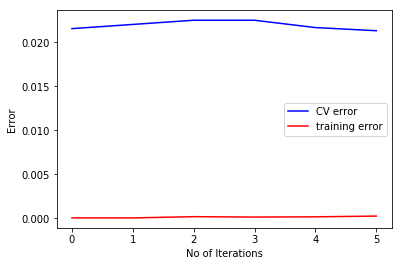

In [243]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC

def supportVM(X_train2, y_train2, X_test2, y_test2, penalty):
    regr = SVC(kernel ='rbf', C=penalty)
    regr.fit(X_train2, y_train2)
    score1 = regr.score(X_train2, y_train2)
    score2 = regr.score(X_test2, y_test2)
    print(score1, score2)
    Prediction = regr.predict(X_test2)
    return score1, score2, Prediction

X_train1, X_test1 = PrincipalComponents(0.81)
print(X_test1.shape, X_train1.shape)

sigma = np.std(X_train1, axis = 0)
mean = np.mean(X_train1, axis = 0)

X_train1 = normalize(sigma , mean , X_train1)
X_test1 = normalize(sigma , mean, X_test1)

J1 = []
J2 = []
for i in range(25000, X_train1.shape[0], 1500):
    score1, score2, Prediction = supportVM(X_train1[:i+1,:], 
                                                    y_train[:i+1, ], X_test1[:i+1,:], y_test[:i+1],10)
    J1.append(1-score1)
    J2.append(1-score2)
    
plt.plot(J2, 'b-', label = "CV error")
plt.plot(J1, 'r-', label ="training error")
plt.legend()
plt.ylabel("Error")
plt.xlabel("No of Iterations")
plt.show()

Saving prediction trained with SVM

In [244]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC
# poly = PolynomialFeatures(include_bias = False)

X1 = X.copy()
Test1 = Test.copy()

pca = PCA(n_components= 0.8388)
X1 = pca.fit_transform(X1)
Test1 = pca.transform(Test)

print(X1.shape, Test1.shape)

print(X1.shape, Test1.shape)

sigma = np.std(X1, axis = 0)
mean = np.mean(X1, axis = 0)

X1 = normalize(sigma, mean, X1)
Test1 = normalize(sigma , mean, Test1)
print(X1.shape, Test1.shape)


regr = SVC(kernel ='rbf', C=10)
regr.fit(X1, Y)
score1 = regr.score(X1, Y)
print(score1)
Prediction = regr.predict(Test1)
Prediction = regr.predict(Test1)
image_id = np.arange(1,Prediction.shape[0]+1)
pd.DataFrame({"ImageId": image_id, "Label": Prediction}).to_csv('datasets/mnist/svm_output.csv', 
                                                                      index=False, header=True)

(42000, 51) (28000, 51)
(42000, 51) (28000, 51)
(42000, 51) (28000, 51)
0.9999285714285714
